# 02-02 : Time Series

Experiment with the data as a time series.

In [2]:
import sys
import gc
import logging

from typing import Iterable
from typing import Tuple, List

import pandas as pd
import numpy as np

import keras
from keras import optimizers
from keras.models import Sequential, Model

from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.layers import LeakyReLU, LSTM, MaxPooling2D, concatenate, Reshape
from keras.layers import Concatenate

from keras.layers import Input
from keras import callbacks
from keras import regularizers

from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

2023-03-14 14:28:32.041533: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configure Logging

In [3]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

In [4]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
        handlers=[
        logging.FileHandler("ex05_06.log"),
        logging.StreamHandler(sys.stdout)
    ])

logging.info("Started")

2023-03-14 14:28:34 INFO     Started


## Load Source Data

In [5]:
# load the source training set
df_source = pd.read_csv('../data/train.csv.gz', compression='gzip')

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [6]:
# load the source training labels
df_source_labels = pd.read_csv('../data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Functions

In [7]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

In [8]:
def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 
        
    return df_labels

In [9]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)

    return df_main

## Data Preprocessing

In [10]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13174211, 14)


,session_id,index,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,2,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [11]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


## Functions to Create Features

In [12]:
def create_initial_features(X:pd.DataFrame,
                            y:pd.DataFrame) -> pd.DataFrame:
    """
    Creates the initial dataset to which features will be added.
    """
    return df_source_labels \
        .groupby(['session_id', 'level_group']) \
        .agg({'correct': ['count']}) \
        .reset_index() \
        .droplevel(1, axis=1) \
        .drop(columns=['correct']) \
        .sort_values(['session_id', 'level_group']) \

# test the function
df_features = create_initial_features(df_source, df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_features.head(6))

,session_id,level_group
0,20090312431273200,0-4
1,20090312431273200,13-22
2,20090312431273200,5-12
3,20090312433251036,0-4
4,20090312433251036,13-22
5,20090312433251036,5-12


### Time Series

In [27]:
# the list of all categorical columns
CATEGORICAL_COLUMNS = [
    'event_name',
    'name',
    'level',
    'fqid',
    'room_fqid',
    'text_fqid'
]

In [33]:
print('UNIQUE COUNT')
for column in CATEGORICAL_COLUMNS:
    print(f'\t{column.ljust(11)}:', df_source[column].nunique())


UNIQUE COUNT
	event_name : 11
	name       : 6
	level      : 23
	fqid       : 127
	room_fqid  : 19
	text_fqid  : 126


In [35]:
# the categorical columns to use, and the order they are when limiting 
# the number to include.
SELECTED_CATEGORICAL_COLUMNS = [
    'level',
    'event_name',
    'room_fqid'
    'name',
    'text_fqid'
]

# the base columns to include in the time series
STANDARD_COLUMNS = [
    'session_id',
    'index',
    'elapsed_time'
]

/tmp/ipykernel_834/3918177049.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['time_diff'] = df_selected['elapsed_time'] \


,session_id,index,elapsed_time,level,time_diff


<Axes: >

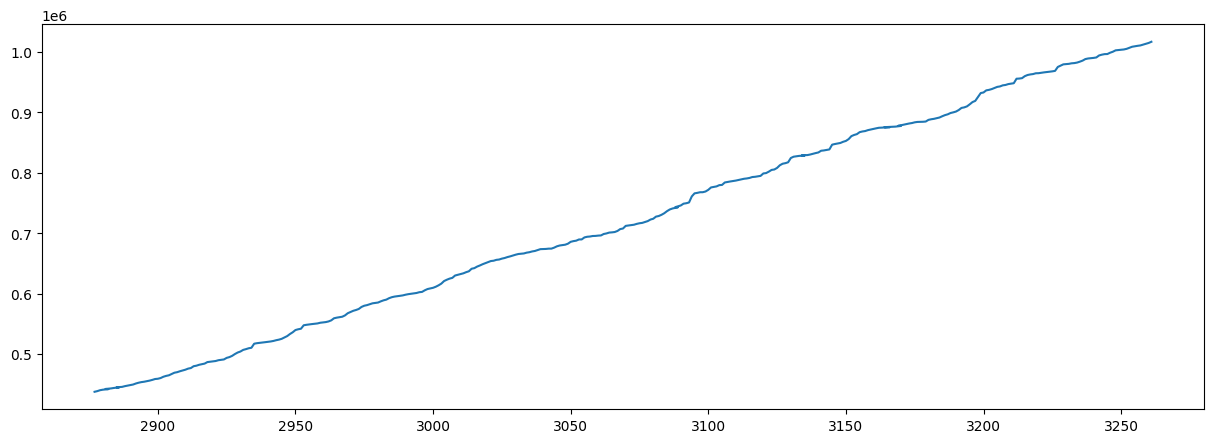

In [70]:
# select the session
#session_id = 20110410405810250
session_id = df_source.session_id.unique()[2]
df_session = df_source[df_source['session_id'] == session_id]

# select the level group
level_group = '5-12'
df_level_group = df_session[df_session['level_group'] == level_group] \
    .sort_values('index') \
    
# select the columns to use in the time series
cat_count = 1   # the number of categorical columns to include
df_selected = df_level_group[
    STANDARD_COLUMNS + 
    SELECTED_CATEGORICAL_COLUMNS[:cat_count]]

# add the time difference between events
df_selected['time_diff'] = df_selected['elapsed_time'] \
    .diff() \
    .fillna(0)

# show negative differences
display(df_selected[df_selected['time_diff'] < 0])


df_selected['elapsed_time'].plot(kind='line', figsize=(15, 5))


# display(df_selected)
# display(df_selected.time_diff.describe())
#df_selected['time_diff'].plot(kind='line', figsize=(15, 5))